In [89]:
# To restart the kernel and clear all variables, run this magic command:
# %reset -f

In [90]:
from matplotlib.ticker import MultipleLocator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import matplotlib.cm as cm
import numpy as np
from importlib import reload
from IPython.display import clear_output
import string

import decid_package.my_functions as decid
import decid_package.my_plotfunctions as plotf

In [91]:
reload(decid)
reload(plotf)

<module 'decid_package.my_plotfunctions' from 'c:\\Users\\decle\\_GABON_TREE_EXPLORATION_PROJECT\\scripts\\decid_package\\my_plotfunctions.py'>

In [92]:
from matplotlib import rcParams

rcParams.update({
    'axes.titlesize': 18,    # a bit bigger
    'axes.labelsize': 14,    # slightly larger
    'xtick.labelsize': 12,   # easier to read
    'ytick.labelsize': 12,
    'legend.fontsize': 14
})

# IMPORT

In [93]:
df_tomst = pd.read_csv("../outputs/df_tomst_cleaned.csv")
df_tomst['DateTime'] = pd.to_datetime(df_tomst['DateTime'])

df_natkon = pd.read_csv("../outputs/df_natkon_cleaned.csv")
df_natkon['DateTime'] = pd.to_datetime(df_natkon['DateTime'])

df_sap_flow = pd.read_csv("../outputs/df_sap_flow_cleaned.csv")
df_sap_flow['DateTime'] = pd.to_datetime(df_sap_flow['DateTime'])

df_phenocam = pd.read_csv("../outputs/df_phenocam_cleaned.csv")
df_phenocam['DateTime'] = pd.to_datetime(df_phenocam['DateTime'])

In [94]:
# # # datatypes of columns
# print(df_tomst.dtypes)
# print(df_phenocam.dtypes)
# print(df_phenocam.head())

# ANALYSIS

## resample

In [95]:
# comparision requires same timestamps in both datasets
df_sap_flow_20 = df_sap_flow.set_index('DateTime').resample('20min').mean().reset_index()
df_natkon_20 = df_natkon.set_index('DateTime').resample('20min').mean().reset_index()
df_tomst_20 = df_tomst.set_index('DateTime').resample('20min').mean().reset_index()

# align on DateTime
# use datetime range from natkon for full range
start_time = df_natkon_20['DateTime'].min()
end_time = df_natkon_20['DateTime'].max()

df_sap_flow_20 = df_sap_flow_20[(df_sap_flow_20['DateTime'] >= start_time) & (df_sap_flow_20['DateTime'] <= end_time)]
df_tomst_20 = df_tomst_20[(df_tomst_20['DateTime'] >= start_time) & (df_tomst_20['DateTime'] <= end_time)]


In [96]:
# daily resample first
# align on DateTime
# use datetime range from natkon for full range
natkon_daily = df_natkon.set_index('DateTime').resample('D').mean().reset_index()

start_time = natkon_daily['DateTime'].min()
end_time = natkon_daily['DateTime'].max()

tomst_daily = df_tomst.set_index('DateTime').resample('D').mean().reset_index()
tomst_daily = tomst_daily[(tomst_daily['DateTime'] >= start_time) & (tomst_daily['DateTime'] <= end_time)]

sapflow_daily = df_sap_flow.set_index('DateTime').resample('D').mean().reset_index()
sapflow_daily = sapflow_daily[(sapflow_daily['DateTime'] >= start_time) & (sapflow_daily['DateTime'] <= end_time)]

# print(natkon_daily.columns)
# print(tomst_daily.columns)
# print(sapflow_daily.columns)

### plots

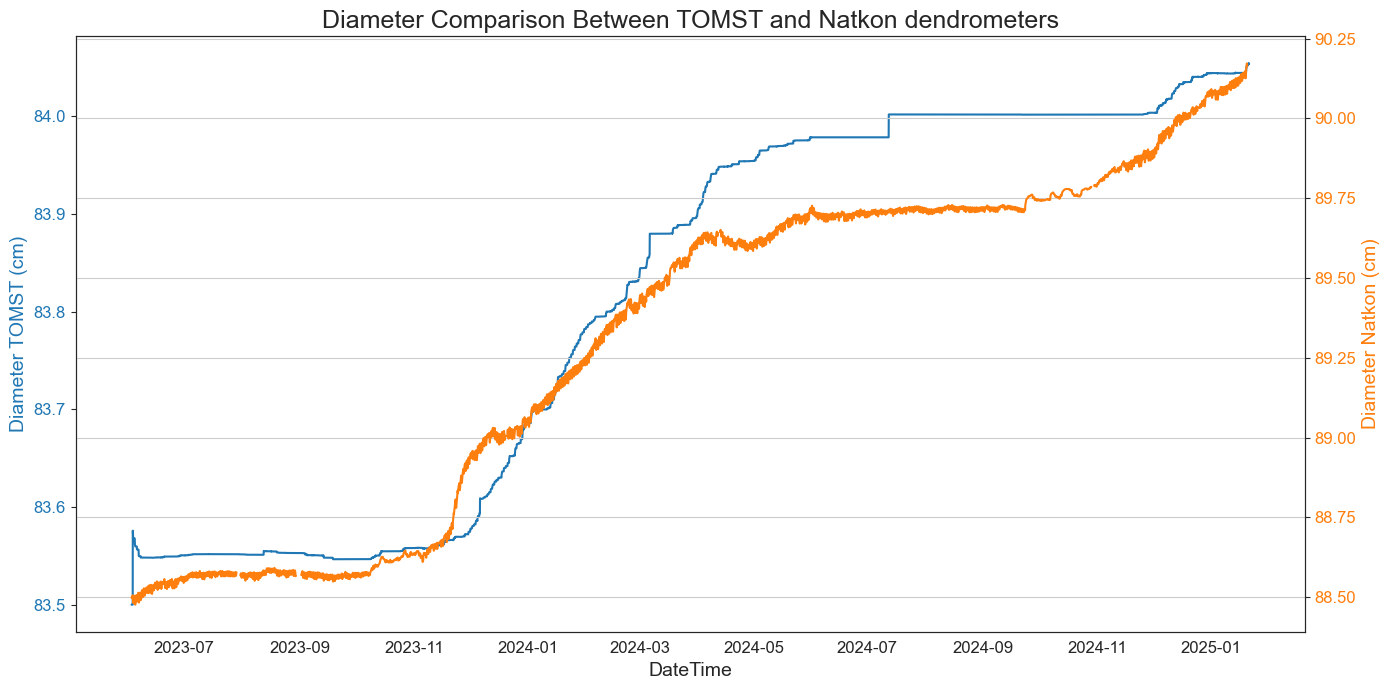

In [97]:

fig, ax1 = plt.subplots(figsize=(14, 7))

color1 = 'tab:blue'
ax1.set_xlabel('DateTime')
ax1.set_ylabel('Diameter TOMST (cm)', color=color1)
ax1.plot(df_tomst_20['DateTime'], df_tomst_20['Diameter (cm)'], label='TOMST', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.set_ylabel('Diameter Natkon (cm)', color=color2)
ax2.plot(df_natkon_20['DateTime'], df_natkon_20['Diameter (cm)'], label='Natkon', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Diameter Comparison Between TOMST and Natkon dendrometers')
fig.tight_layout()
plt.grid()
plt.show()

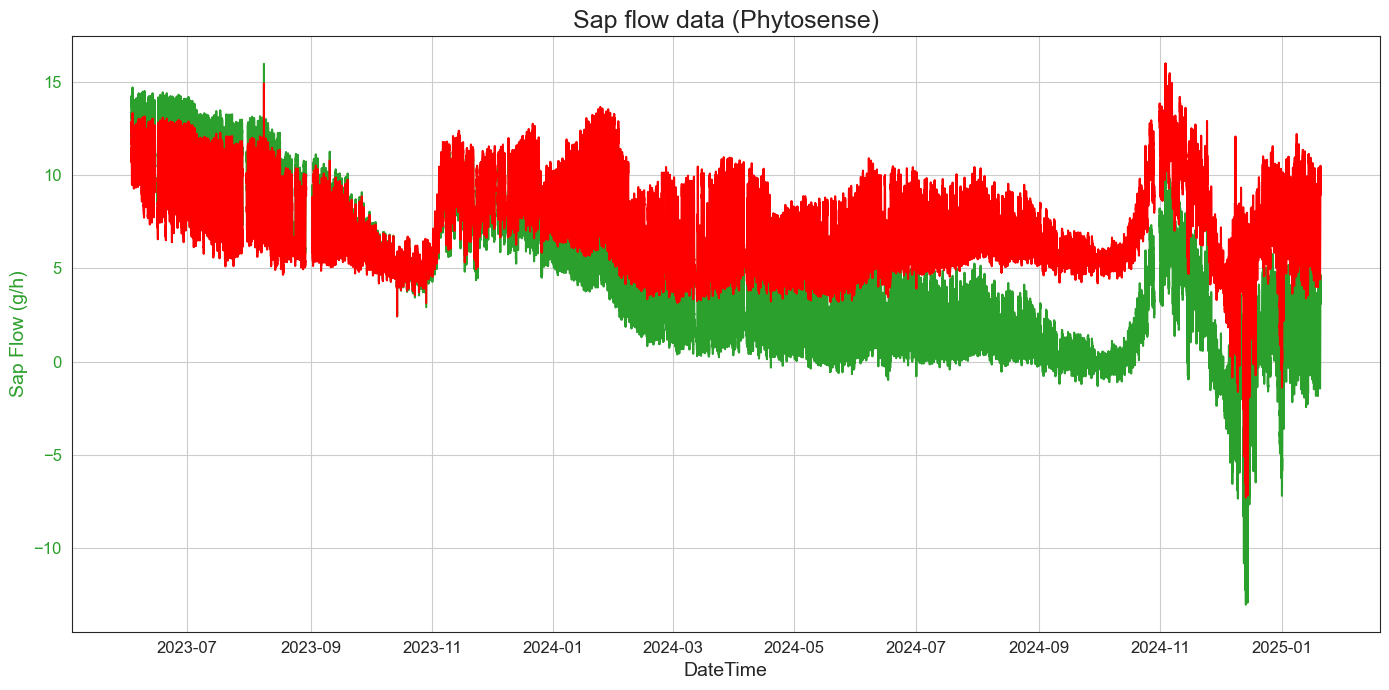

In [98]:
# plot sap flow data
fig, ax1 = plt.subplots(figsize=(14, 7))
color1 = 'tab:green'
ax1.set_xlabel('DateTime')
ax1.set_ylabel('Sap Flow (g/h)', color=color1)
ax1.plot(df_sap_flow_20['DateTime'], df_sap_flow_20['Sap_flow'], label='Sap Flow', color=color1)
ax1.plot(df_sap_flow_20['DateTime'], df_sap_flow_20['Detrended_flow'], label='Detrended Flow', color='red')
ax1.tick_params(axis='y', labelcolor=color1)

plt.title('Sap flow data (Phytosense)')
fig.tight_layout()
plt.grid()
plt.show()


## cross correlation NOT USED

#### resampling

#### correlation functions

In [99]:
def cross_correlation_table(a: pd.Series, b: pd.Series, max_lag: int = 14) -> pd.DataFrame:
    """
    Compute cross-correlation for lags in [-max_lag, +max_lag].
    Positive lag => series a leads b by 'lag' days.
    """
    df = pd.concat([a, b], axis=1).dropna()
    if df.empty:
        return pd.DataFrame(columns=["lag", "corr"])
    a2, b2 = df.iloc[:,0], df.iloc[:,1]
    out = []
    for lag in range(-max_lag, max_lag+1):
        if lag > 0:
            corr = a2.iloc[:-lag].corr(b2.iloc[lag:])
        elif lag < 0:
            corr = a2.iloc[-lag:].corr(b2.iloc[:lag])
        else:
            corr = a2.corr(b2)
        out.append((lag, corr))
    return pd.DataFrame(out, columns=["lag", "corr"]).sort_values("lag")

In [100]:
def plot_cross_correlation(cc_df: pd.DataFrame, title: str = "Cross-correlation"):
    """
    Plot cross-correlation vs lag.
    
    cc_df: DataFrame returned by cross_correlation_table (columns: 'lag', 'corr')
    """
    plt.figure(figsize=(10, 5))
    plt.plot(cc_df['lag'], cc_df['corr'], marker='o', linestyle='-')
    plt.axhline(0, color='black', linewidth=0.8)
    
    # Highlight maximum correlation
    max_idx = cc_df['corr'].abs().idxmax()
    max_lag = cc_df.loc[max_idx, 'lag']
    max_corr = cc_df.loc[max_idx, 'corr']
    plt.scatter(max_lag, max_corr, color='red', zorder=5)
    plt.text(max_lag, max_corr + 0.02, f"Max: {max_corr:.2f} at lag {max_lag}", color='red')
    
    plt.xlabel("Lag (days)")
    plt.ylabel("Correlation")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


#### correlation

In [101]:
# cc_detrended = cross_correlation_table(natkon_20['detrended_short'], 
#                                       sapflow_20['detrended_short'], max_lag=14)

# cc_multi_day = cross_correlation_table(natkon_daily['detrended_long'], 
#                                        sapflow_daily['detrended_long'], max_lag=180)


In [102]:
# plt.figure(figsize=(8,5))
# # plt.plot(cc_detrended['lag'], cc_detrended['corr'], label='High freq', color='blue')
# plt.plot(cc_multi_day['lag'], cc_multi_day['corr'], label='Multi-day', color='green')
# plt.axvline(0, color='k', linestyle='--')
# plt.xlabel('Lag (days, positive: dendrometer leads)')
# plt.ylabel('Correlation')
# plt.title('Natkon ↔ Sap flow cross-correlation')
# plt.legend()
# plt.grid(True)
# plt.show()


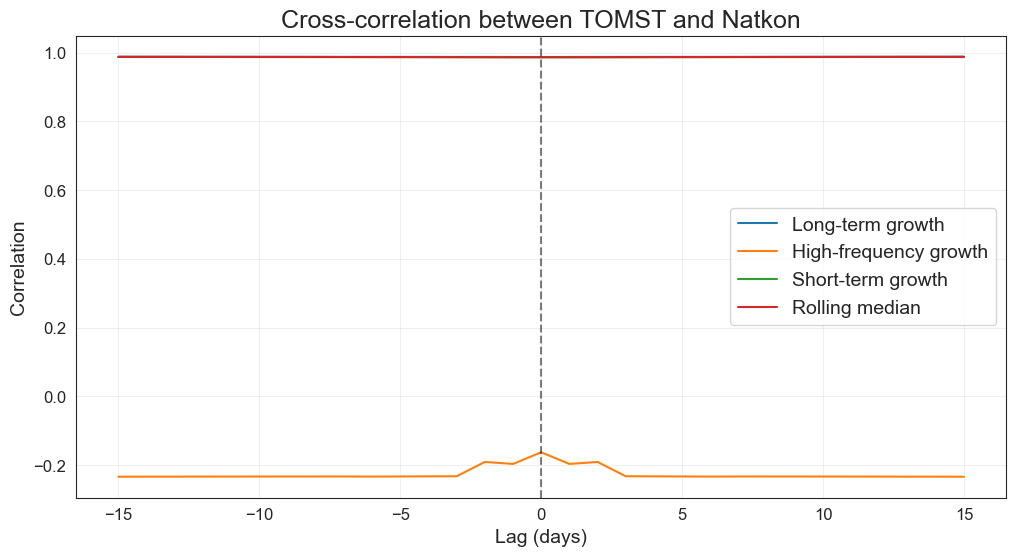

In [103]:
# DENDROMETER CROSS CORRELATION
# compute lagged correlation up to 14 days
cc_long_term_growth = cross_correlation_table(tomst_daily['long_trend'], 
                                              natkon_daily['long_trend'], max_lag=15)
cc_high_freq = cross_correlation_table(tomst_daily['detrended_short'], 
                                       natkon_daily['detrended_short'], max_lag=15)
cc_short_term_growth = cross_correlation_table(tomst_daily['short_trend'],
                                               natkon_daily['short_trend'], max_lag=15)
# cc_diurnal_ampl = cross_correlation_table(tomst_daily['amp_12h'],
#                                           natkon_daily['amp_12h'], max_lag=15)
cc_roll = cross_correlation_table(tomst_daily['smoothed_signal'],
                                  natkon_daily['smoothed_signal'], max_lag=15)
plt.figure(figsize=(12, 6))

# Plot all cross-correlations
plt.plot(cc_long_term_growth['lag'], cc_long_term_growth['corr'], label='Long-term growth')
plt.plot(cc_high_freq['lag'], cc_high_freq['corr'], label='High-frequency growth')
plt.plot(cc_short_term_growth['lag'], cc_short_term_growth['corr'], label='Short-term growth')
# plt.plot(cc_diurnal_ampl['lag'], cc_diurnal_ampl['corr'], label='Diurnal amplitude')
plt.plot(cc_roll['lag'], cc_roll['corr'], label='Rolling median')

plt.axvline(0, color='black', linestyle='--', alpha=0.5)  # zero lag reference
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.title('Cross-correlation between TOMST and Natkon')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



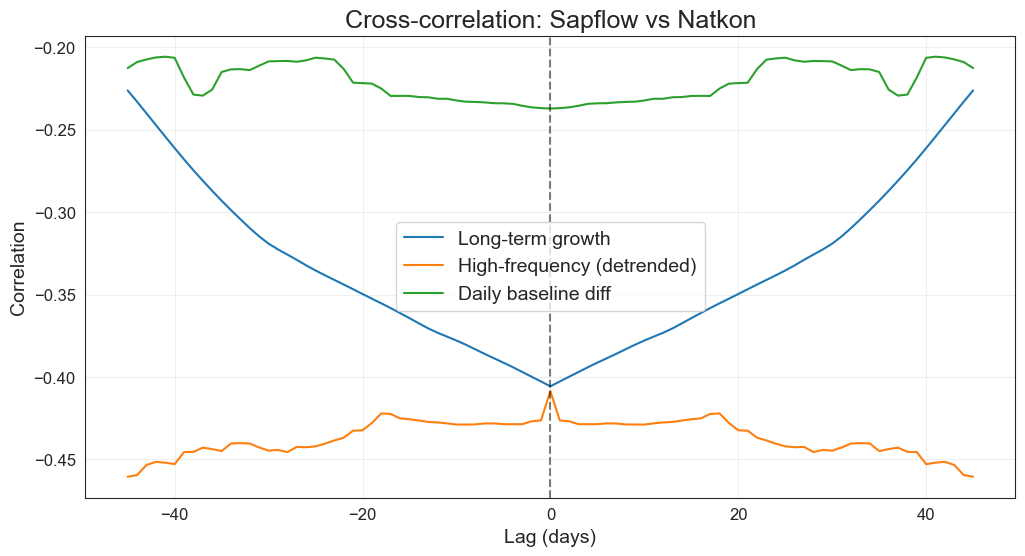

In [104]:
# DENDRO <-> SAP FLOW CROSS CORRELATION
cc_sap_dendro_long_term_growt = cross_correlation_table(sapflow_daily['long_trend'], 
                                                        natkon_daily['long_trend'], max_lag=45)
cc_sap_dendro_short_detrended = cross_correlation_table(sapflow_daily['detrended_short'], 
                                                        natkon_daily['detrended_short'], max_lag=45)
cc_sap_dendro_dday_diff = cross_correlation_table(sapflow_daily['short_trend_dday_diff'], 
                                                   natkon_daily['short_trend_dday_diff'], max_lag=45)

plt.figure(figsize=(12, 6))

# Plot cross-correlations
plt.plot(cc_sap_dendro_long_term_growt['lag'], cc_sap_dendro_long_term_growt['corr'], label='Long-term growth')
plt.plot(cc_sap_dendro_short_detrended['lag'], cc_sap_dendro_short_detrended['corr'], label='High-frequency (detrended)')
plt.plot(cc_sap_dendro_dday_diff['lag'], cc_sap_dendro_dday_diff['corr'], label='Daily baseline diff')

plt.axvline(0, color='black', linestyle='--', alpha=0.5)  # zero lag reference
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.title('Cross-correlation: Sapflow vs Natkon')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Dendrometer data: centering and incremental growth

fix growth here or make in water relations?????????????

#### GROWTH

In [105]:
# # Make sure DateTime is datetime
# df_tomst_20['DateTime'] = pd.to_datetime(df_tomst_20['DateTime'])

# # Extract the date (day)
# df_tomst_20['Date'] = df_tomst_20['DateTime'].dt.date

# # Get first measurement of the day (assume 00:00 is first)
# first_per_day = df_tomst_20.groupby('Date')['smoothed_signal'].first().rename('first')

# # Join back the first measurement per day
# df_tomst_20 = df_tomst_20.merge(first_per_day, on='Date')

# # Delta-corrected growth relative to first measurement
# df_tomst_20['Growth'] = df_tomst_20['smoothed_signal'] - df_tomst_20['first']

# # same for df_natkon
# df_natkon_20['DateTime'] = pd.to_datetime(df_natkon_20['DateTime'])
# df_natkon_20['Date'] = df_natkon_20['DateTime'].dt.date
# first_per_day = df_natkon_20.groupby('Date')['smoothed_signal'].first().rename('first')
# df_natkon_20 = df_natkon_20.merge(first_per_day, on='Date')
# df_natkon_20['Growth'] = df_natkon_20['smoothed_signal'] - df_natkon_20['first']


# # also for sap flow
# df_sap_flow_20['DateTime'] = pd.to_datetime(df_sap_flow_20['DateTime'])
# df_sap_flow_20['Date'] = df_sap_flow_20['DateTime'].dt.date
# first_per_day = df_sap_flow_20.groupby('Date')['smoothed_signal'].first().rename('first')
# df_sap_flow_20 = df_sap_flow_20.merge(first_per_day, on='Date')
# df_sap_flow_20['Daily_increase'] = df_sap_flow_20['smoothed_signal'] - df_sap_flow_20['first']



In [106]:
# # Define zoom period
# zoom_start = pd.Timestamp('2023-11-10')
# zoom_end = pd.Timestamp('2023-11-16')

# # Filter data for zoom period
# df_tomst_zoom = df_tomst_20[(df_tomst_20['DateTime'] >= zoom_start) & (df_tomst_20['DateTime'] <= zoom_end)]
# df_natkon_zoom = df_natkon_20[(df_natkon_20['DateTime'] >= zoom_start) & (df_natkon_20['DateTime'] <= zoom_end)]

# # Plot zoomed growth
# fig, ax1 = plt.subplots(figsize=(14, 7))
# color1 = 'tab:blue'
# ax1.set_xlabel('DateTime')
# ax1.set_ylabel('Growth TOMST (cm)', color=color1)
# ax1.plot(df_tomst_zoom['DateTime'], df_tomst_zoom['Growth'], label='TOMST', color=color1)
# # ax1.plot(df_tomst_zoom['DateTime'], df_tomst_zoom['detrended_daily_mean'], label='TOMST', color='darkblue')
# ax1.tick_params(axis='y', labelcolor=color1)

# ax2 = ax1.twinx()
# color2 = 'tab:orange'
# ax2.set_ylabel('Growth Natkon (cm)', color=color2)
# ax2.plot(df_natkon_zoom['DateTime'], df_natkon_zoom['Growth'], label='Natkon', color=color2)
# # ax2.plot(df_natkon_zoom['DateTime'], df_natkon_zoom['detrended_daily_mean'], label='Natkon', color='red')
# ax2.tick_params(axis='y', labelcolor=color2)

# plt.title('Growth Comparison (Zoomed Period)')
# fig.tight_layout()
# plt.grid()
# plt.show()

## aggregate sets

#### aggregation

In [107]:
# aggregate sets
tomst_columns = ['smoothed_signal'] # also 'growth' when fixed
natkon_columns = ['smoothed_signal']
sap_flow_columns = ['smoothed_signal']

df_tomst_multi_sum = decid.summarize_multi_levels(df_tomst_20, value_cols=tomst_columns, rolling_window= "10d")
df_natkon_multi_sum = decid.summarize_multi_levels(df_natkon_20, value_cols=natkon_columns, rolling_window= "10d")
df_sap_flow_multi_sum = decid.summarize_multi_levels(df_sap_flow_20, value_cols=sap_flow_columns, rolling_window= "10d")


In [108]:
print(df_tomst_multi_sum.columns)
# print(df_natkon_multi_sum.columns)
# print(df_sap_flow_multi_sum.columns)

# clear_output()

Index(['DateTime', 'temp', 'displacement (µm)', 'Corrected', 'Diameter (cm)',
       'flat_flag', 'missing', 'gap_block', 'large_gap', 'Growth_cumulative',
       'smoothed_signal', 'daily_mean', 'detrended_daily_mean', 'short_trend',
       'detrended_short', 'long_trend', 'detrended_long',
       'short_trend_dday_diff', 'smoothed_signal_roll10d',
       'smoothed_signal_mean_D', 'smoothed_signal_min_D',
       'smoothed_signal_max_D', 'smoothed_signal_mean_W',
       'smoothed_signal_min_W', 'smoothed_signal_max_W',
       'smoothed_signal_mean_M', 'smoothed_signal_min_M',
       'smoothed_signal_max_M'],
      dtype='object')


#### plots

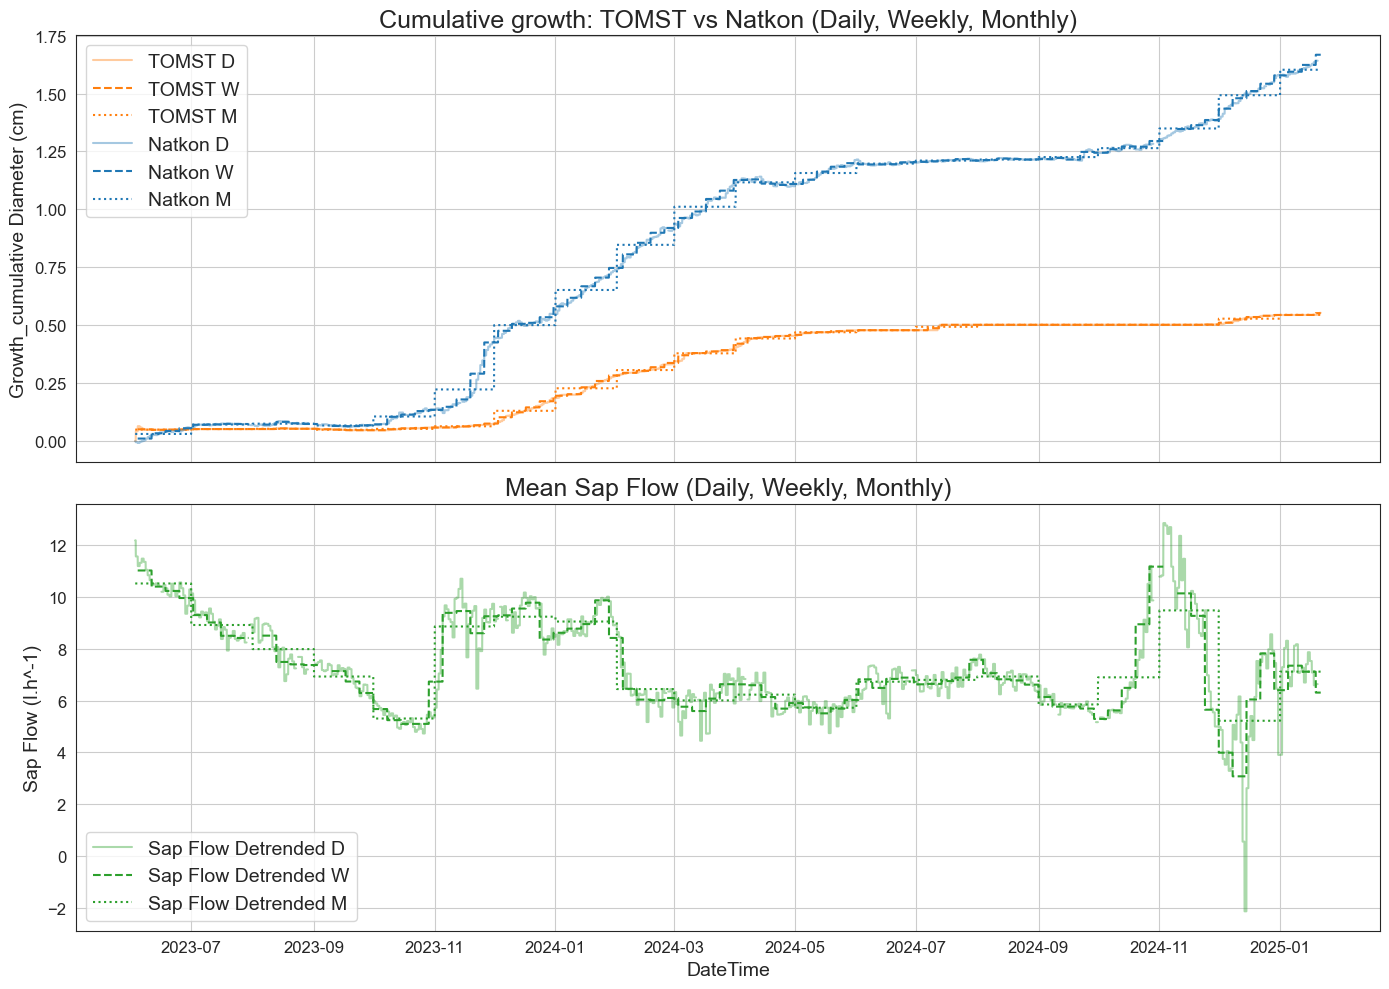

In [109]:
# Define sensor colors
sensor_colors = plotf.get_color_maps()['sensor']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot settings
agg_styles = {'D': ('-', 0.4, None), 'W': ('--', 1, None), 'M': (':', 1, None)}

# Top plot: Growth_cumulative for TOMST and Natkon
for sensor_df, name, color in zip([df_tomst_multi_sum, df_natkon_multi_sum], 
                                  ['TOMST', 'Natkon'], 
                                  [sensor_colors['TOMST'], sensor_colors['Natkon']]):
    for agg, (ls, alpha, marker) in agg_styles.items():
        ax1.plot(sensor_df['DateTime'], sensor_df[f'smoothed_signal_mean_{agg}'], 
                 label=f'{name} {agg}', color=color, linestyle=ls, alpha=alpha,
                 marker=marker, markersize=1 if marker else None)

ax1.set_ylabel('Growth_cumulative Diameter (cm)')
ax1.set_title('Cumulative growth: TOMST vs Natkon (Daily, Weekly, Monthly)')
ax1.legend()
ax1.grid()

# Bottom plot: Sap Flow
for col, color, label_prefix in zip(
    ['smoothed_signal_mean',], 
    [sensor_colors['Sap Flow']], 
    ['Sap Flow Detrended']
):
    for agg, (ls, alpha, marker) in agg_styles.items():
        ax2.plot(df_sap_flow_multi_sum['DateTime'], df_sap_flow_multi_sum[f'{col}_{agg}'],
                 label=f'{label_prefix} {agg}', color=color, linestyle=ls, alpha=alpha,
                 marker=marker, markersize=1 if marker else None)

ax2.set_ylabel('Sap Flow (l.h^-1)')
ax2.set_title('Mean Sap Flow (Daily, Weekly, Monthly)')
ax2.legend()
ax2.grid()

plt.xlabel('DateTime')
plt.tight_layout()
plt.show()


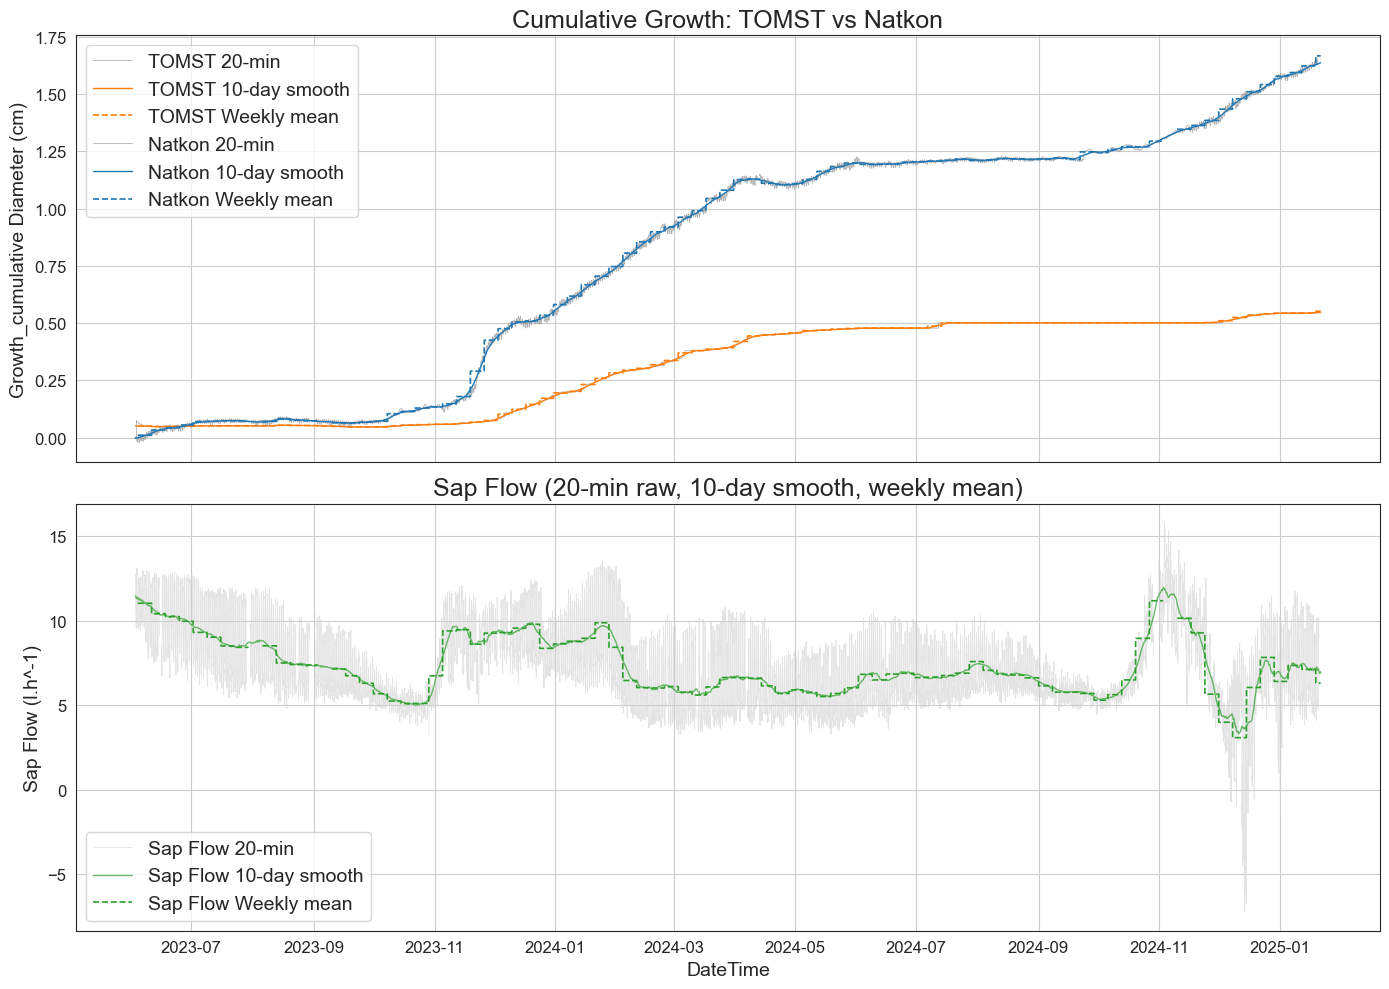

In [110]:
# Define sensor colors
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# ---- Top plot: Growth_cumulative TOMST and Natkon ----
for sensor_df, name in zip([df_tomst_multi_sum, df_natkon_multi_sum], ['TOMST', 'Natkon']):
    # Raw 20-min data
    ax1.plot(sensor_df['DateTime'], sensor_df['smoothed_signal'], 
             label=f'{name} 20-min', color='gray', linewidth=0.6, alpha=0.6)
    
    # 10-day rolling mean
    ax1.plot(sensor_df['DateTime'], sensor_df['smoothed_signal_roll10d'], 
             label=f'{name} 10-day smooth', color=sensor_colors[name], linewidth=1.0)
    
    # Weekly mean
    ax1.plot(sensor_df['DateTime'], sensor_df['smoothed_signal_mean_W'], 
             label=f'{name} Weekly mean', color=sensor_colors[name], linewidth=1.2, linestyle='--')

ax1.set_ylabel('Growth_cumulative Diameter (cm)')
ax1.set_title('Cumulative Growth: TOMST vs Natkon')
ax1.legend()
ax1.grid(True)

# ---- Bottom plot: Sap Flow ----
for col, rolling_col, weekly_col, label_prefix in zip(
        ['smoothed_signal'], 
        ['smoothed_signal_roll10d'], 
        ['smoothed_signal_mean_W'], 
        ['Sap Flow']
    ):
    # Raw 20-min data
    ax2.plot(df_sap_flow_multi_sum['DateTime'], df_sap_flow_multi_sum[col], 
             label=f'{label_prefix} 20-min', color='lightgray', linewidth=0.6, alpha=0.6)
    
    # 10-day rolling mean
    ax2.plot(df_sap_flow_multi_sum['DateTime'], df_sap_flow_multi_sum[rolling_col], 
             label=f'{label_prefix} 10-day smooth', color=sensor_colors[label_prefix], linewidth=1.0, alpha = 0.7)
    
    # Weekly mean
    ax2.plot(df_sap_flow_multi_sum['DateTime'], df_sap_flow_multi_sum[weekly_col], 
             label=f'{label_prefix} Weekly mean', color=sensor_colors[label_prefix], linewidth=1.2, linestyle='--')

ax2.set_ylabel('Sap Flow (l.h^-1)')
ax2.set_title('Sap Flow (20-min raw, 10-day smooth, weekly mean)')
ax2.legend()
ax2.grid(True)

plt.xlabel('DateTime')
plt.tight_layout()
plt.show()


## Seasonal comparison

#### add periods and merge for plotting

In [111]:
reload(decid)

<module 'decid_package.my_functions' from 'c:\\Users\\decle\\_GABON_TREE_EXPLORATION_PROJECT\\scripts\\decid_package\\my_functions.py'>

In [112]:
# Apply period normalization for all sensors and value columns
value_cols=['smoothed_signal', 
            'smoothed_signal_mean_D', 
            'smoothed_signal_mean_W',
            'smoothed_signal_mean_M',
            'smoothed_signal_roll10d']

df_tomst_norm = (decid.add_period_normalization(
    df_tomst_multi_sum, 
    value_cols=value_cols, 
    rescale=True
).drop(columns = ['large_gap', 'temp', 'displacement (µm)', 'Corrected', 'Diameter (cm)'])
.rename(columns={'Growth_cumulative': 'raw_signal'})
)
df_tomst_norm['Sensor'] = 'TOMST'

df_natkon_norm = (decid.add_period_normalization(
    df_natkon_multi_sum, 
    value_cols=value_cols, 
    rescale=True)
.drop(columns = ['large_gap'])
.rename(columns={'Growth_cumulative': 'raw_signal'})
)
df_natkon_norm['Sensor'] = 'Natkon'

df_sap_flow_norm = decid.add_period_normalization(
    df_sap_flow_multi_sum, 
    value_cols=value_cols, 
    rescale=False
).drop(columns =['Sap_flow', 'large_gap']).rename(columns={'Detrended_flow': 'raw_signal'})
df_sap_flow_norm['Sensor'] = 'Sap Flow'



df_all_norm = pd.concat([df_tomst_norm, df_natkon_norm, df_sap_flow_norm], ignore_index=True)
df_all_norm['flat_flag'] = df_all_norm['flat_flag'].fillna(0).astype(int)


In [113]:
df_all_norm.columns

# clear_output()

Index(['DateTime', 'flat_flag', 'missing', 'gap_block', 'raw_signal',
       'smoothed_signal', 'daily_mean', 'detrended_daily_mean', 'short_trend',
       'detrended_short', 'long_trend', 'detrended_long',
       'short_trend_dday_diff', 'smoothed_signal_roll10d',
       'smoothed_signal_mean_D', 'smoothed_signal_min_D',
       'smoothed_signal_max_D', 'smoothed_signal_mean_W',
       'smoothed_signal_min_W', 'smoothed_signal_max_W',
       'smoothed_signal_mean_M', 'smoothed_signal_min_M',
       'smoothed_signal_max_M', 'Days_since_start', 'Period', 'Day_of_Period',
       'smoothed_signal_pct_global', 'smoothed_signal_pct_period',
       'smoothed_signal_mean_D_pct_global',
       'smoothed_signal_mean_D_pct_period',
       'smoothed_signal_mean_W_pct_global',
       'smoothed_signal_mean_W_pct_period',
       'smoothed_signal_mean_M_pct_global',
       'smoothed_signal_mean_M_pct_period',
       'smoothed_signal_roll10d_pct_global',
       'smoothed_signal_roll10d_pct_period', 'Se

In [114]:
# list of all columns in df_all_norm with _pct_rescaled in the name
df_all_norm.columns[df_all_norm.columns.str.contains('_pct')]

Index(['smoothed_signal_pct_global', 'smoothed_signal_pct_period',
       'smoothed_signal_mean_D_pct_global',
       'smoothed_signal_mean_D_pct_period',
       'smoothed_signal_mean_W_pct_global',
       'smoothed_signal_mean_W_pct_period',
       'smoothed_signal_mean_M_pct_global',
       'smoothed_signal_mean_M_pct_period',
       'smoothed_signal_roll10d_pct_global',
       'smoothed_signal_roll10d_pct_period'],
      dtype='object')

In [115]:
df_all_norm.columns[df_all_norm.columns.str.contains('Detrended')]

Index([], dtype='object')

#### plots

In [116]:
season_colors = plotf.get_color_maps()['season']

In [117]:
plotf.main_plot(df_all_norm, sensor_colors, season_colors, agg_to_plot='20min')
plotf.main_plot(df_all_norm, sensor_colors, season_colors,agg_to_plot='roll10d')

clear_output()

In [118]:
# df_all_norm.columns

## Dendrometer scatterplot

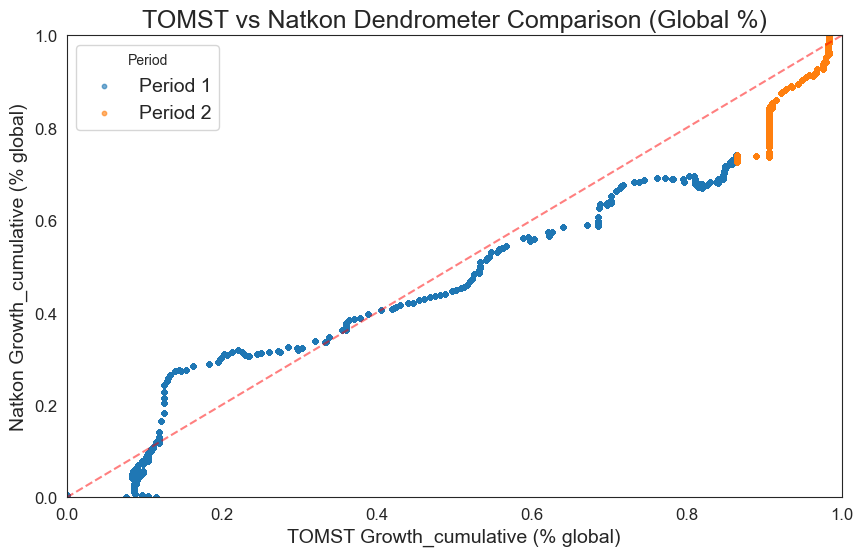

In [119]:
import matplotlib.pyplot as plt

# Filter dendrometer sensors
tomst = df_all_norm[df_all_norm['Sensor'] == 'TOMST']
natkon = df_all_norm[df_all_norm['Sensor'] == 'Natkon']

# Merge on Day_of_Period and Period
merged = tomst.merge(
    natkon,
    on=['Day_of_Period','Period'],
    suffixes=('_TOMST','_Natkon')
)

# Color map per period
periods = sorted(merged['Period'].unique())
colors = plt.cm.tab10.colors  # up to 10 colors, will cycle if >10 periods
period_color_map = {p: colors[i % len(colors)] for i, p in enumerate(periods)}

# Scatter plot
plt.figure(figsize=(10,6))
for p in periods:
    subset = merged[merged['Period']==p]
    plt.scatter(
        subset['smoothed_signal_mean_D_pct_global_TOMST'],
        subset['smoothed_signal_mean_D_pct_global_Natkon'],
        alpha=0.6,
        s=10,
        color=period_color_map[p],
        label=f'Period {p+1}'
    )

plt.xlabel('TOMST Growth_cumulative (% global)')
plt.ylabel('Natkon Growth_cumulative (% global)')
plt.title('TOMST vs Natkon Dendrometer Comparison (Global %)')
plt.plot([0,1],[0,1],'r--', alpha=0.5)  # 1:1 line
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(title='Period')
plt.show()


# PHENOLOGY

## smooth

In [120]:
rolling_days = 2

df_phenocam_period = decid.add_period_normalization(df_phenocam, rescale = False, 
                                                    value_cols = ['%leafs', '%fruits', '%flowers'])
df_phenocam_period['DateTime'] = pd.to_datetime(df_phenocam_period['DateTime']) + pd.Timedelta(hours=10)

df_phenocam_period[f'%leaves_roll{rolling_days}D'] = df_phenocam_period['%leafs'].rolling(rolling_days, center=True, min_periods=1).median()
df_phenocam_period[f'%flowers_roll{rolling_days}D'] = df_phenocam_period["%flowers"].rolling(rolling_days, center=True, min_periods=1).median()
df_phenocam_period[f'%fruits_roll{rolling_days}D'] = df_phenocam_period["%fruits"].rolling(rolling_days, center=True, min_periods=1).median()

In [121]:
# df_phenocam_period.head()

### plot

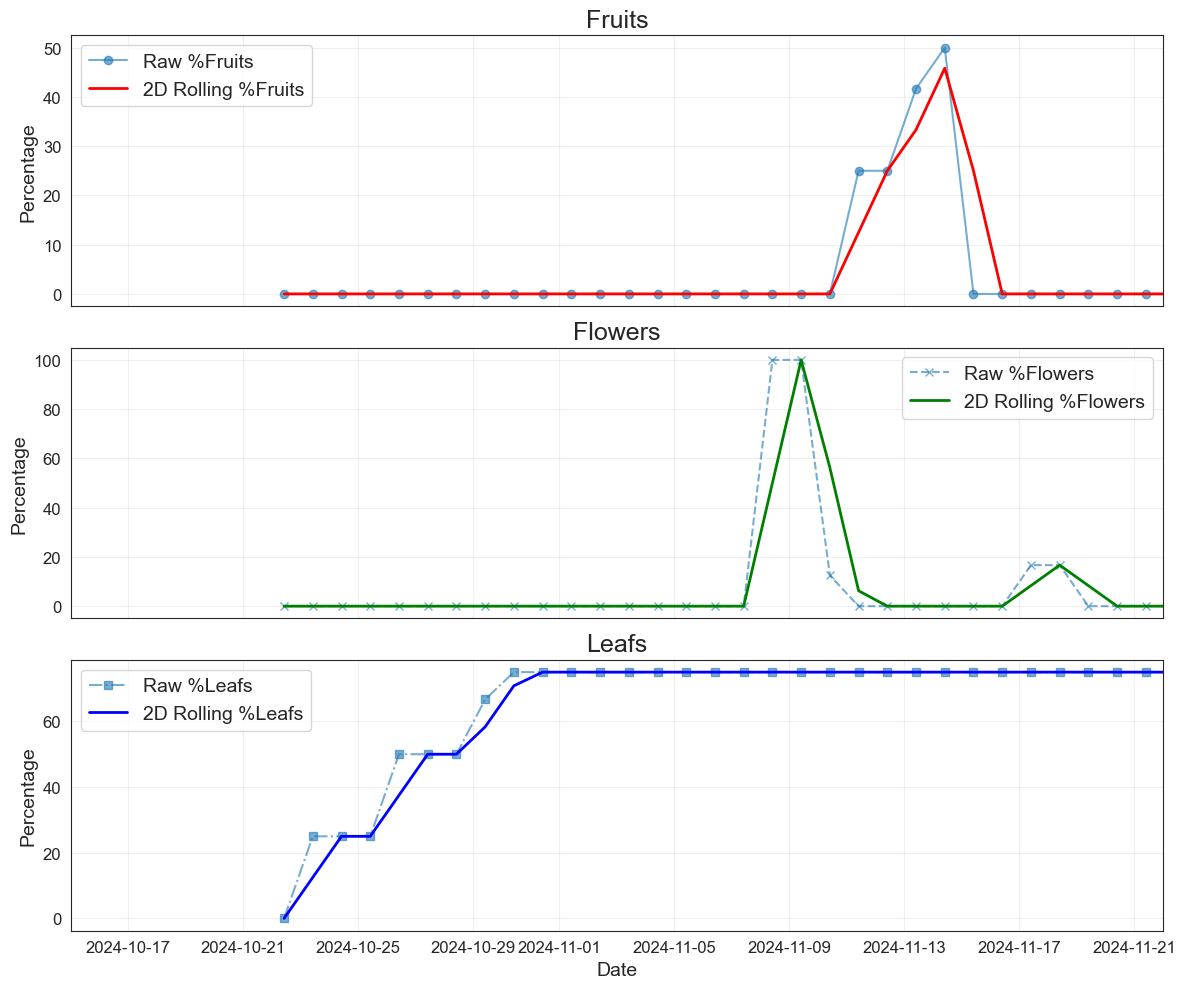

In [122]:
# Zoom period
start_date = '2024-10-15'
end_date = '2024-11-22'
mask = (df_phenocam_period['DateTime'] >= start_date) & (df_phenocam_period['DateTime'] <= end_date)

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# --- Fruits ---
axes[0].plot(df_phenocam_period['DateTime'], df_phenocam_period['%fruits'], label='Raw %Fruits', marker='o', linestyle='-', alpha=0.6)
axes[0].plot(df_phenocam_period['DateTime'], df_phenocam_period[f'%fruits_roll{rolling_days}D'], label=f'{rolling_days}D Rolling %Fruits', color='red', linewidth=2)
axes[0].set_ylabel('Percentage')
axes[0].set_title('Fruits')
axes[0].legend()
axes[0].grid(alpha=0.3)

# --- Flowers ---
axes[1].plot(df_phenocam_period['DateTime'], df_phenocam_period['%flowers'], label='Raw %Flowers', marker='x', linestyle='--', alpha=0.6)
axes[1].plot(df_phenocam_period['DateTime'], df_phenocam_period[f'%flowers_roll{rolling_days}D'], label=f'{rolling_days}D Rolling %Flowers', color='green', linewidth=2)
axes[1].set_ylabel('Percentage')
axes[1].set_title('Flowers')
axes[1].legend()
axes[1].grid(alpha=0.3)

# --- Leafs ---
axes[2].plot(df_phenocam_period['DateTime'], df_phenocam_period['%leafs'], label='Raw %Leafs', marker='s', linestyle='-.', alpha=0.6)
axes[2].plot(df_phenocam_period['DateTime'], df_phenocam_period[f'%leaves_roll{rolling_days}D'], label=f'{rolling_days}D Rolling %Leafs', color='blue', linewidth=2)
axes[2].set_ylabel('Percentage')
axes[2].set_title('Leafs')
axes[2].legend()
axes[2].grid(alpha=0.3)

# Zoom x-axis
axes[2].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
plt.xlabel('Date')
plt.tight_layout()
plt.show()

## detect events

#### data manipulation

In [123]:
leafs = df_phenocam_period['%leafs']
fruits = df_phenocam_period['%fruits']
flowers = df_phenocam_period['%flowers']

# boolean mask
mask = (
    (leafs != 75) & leafs.notna() |
    (fruits != 0) & fruits.notna() |
    (flowers != 0) & flowers.notna()
)

# find contiguous stretches where mask is True
event_groups = (mask != mask.shift()).cumsum()  # unique number per contiguous block
event_blocks = mask.groupby(event_groups).sum()  # count Trues per block

# keep only blocks where mask was True (i.e., event)
event_ids = event_blocks[event_blocks > 0].index.tolist()

# define start/end of each event
events = []
for eid in event_ids:
    block_idx = event_groups[event_groups == eid].index
    start, end = block_idx[0], block_idx[-1]
    events.append((start, end))

# assuming df_phenocam has a 'DateTime' column
events_dates = [(df_phenocam_period.loc[start, 'DateTime'], df_phenocam_period.loc[end, 'DateTime'])
                for start, end in events]

event_types = []

for start_idx, end_idx in events:
    # slice the mask for this event
    leaf_mask   = (leafs < 75).iloc[start_idx:end_idx+1]
    fruit_mask  = (fruits >= 0).iloc[start_idx:end_idx+1]
    flower_mask = (flowers >= 0).iloc[start_idx:end_idx+1]

    counts = {
        "Leaf": leaf_mask.sum(),
        "Fruit": fruit_mask.sum(),
        "Flower": flower_mask.sum()
    }

    max_count = max(counts.values())
    top_signals = [k for k, v in counts.items() if v == max_count]

    if len(top_signals) == 1:
        event_type = top_signals[0]
    else:
        # combine the tied signals
        event_type = "+".join(top_signals)

    event_types.append(event_type)

print("Detected events in dates:")
for e in events_dates:
    print(e)

pre_days = 30
post_days = 30

timeline_records = []

for i, ((start_idx, end_idx), evt_type) in enumerate(zip(events, event_types), start=1):
    win_start = max(0, start_idx - pre_days)
    win_end   = min(len(df_phenocam_period) - 1, end_idx + post_days)

    start_row = df_phenocam_period.iloc[win_start]
    end_row   = df_phenocam_period.iloc[win_end]

    timeline_records.append({
        "DateTime": start_row["DateTime"],
        "Boundary": "start",
        "Event": i,
        "Period": start_row["Period"],
        "Day_of_Period": start_row["Day_of_Period"],
        "Event_Type": evt_type
    })

    timeline_records.append({
        "DateTime": end_row["DateTime"],
        "Boundary": "end",
        "Event": i,
        "Period": end_row["Period"],
        "Day_of_Period": end_row["Day_of_Period"],
        "Event_Type": evt_type
    })

timeline_df = pd.DataFrame(timeline_records)
# print(timeline_df)



Detected events in dates:
(Timestamp('2023-07-30 10:00:00'), Timestamp('2023-08-11 10:00:00'))
(Timestamp('2024-10-22 10:00:00'), Timestamp('2024-10-29 10:00:00'))
(Timestamp('2024-11-08 10:00:00'), Timestamp('2024-11-14 10:00:00'))
(Timestamp('2024-11-17 10:00:00'), Timestamp('2024-11-18 10:00:00'))


In [124]:
reload(plotf)

<module 'decid_package.my_plotfunctions' from 'c:\\Users\\decle\\_GABON_TREE_EXPLORATION_PROJECT\\scripts\\decid_package\\my_plotfunctions.py'>

#### plot

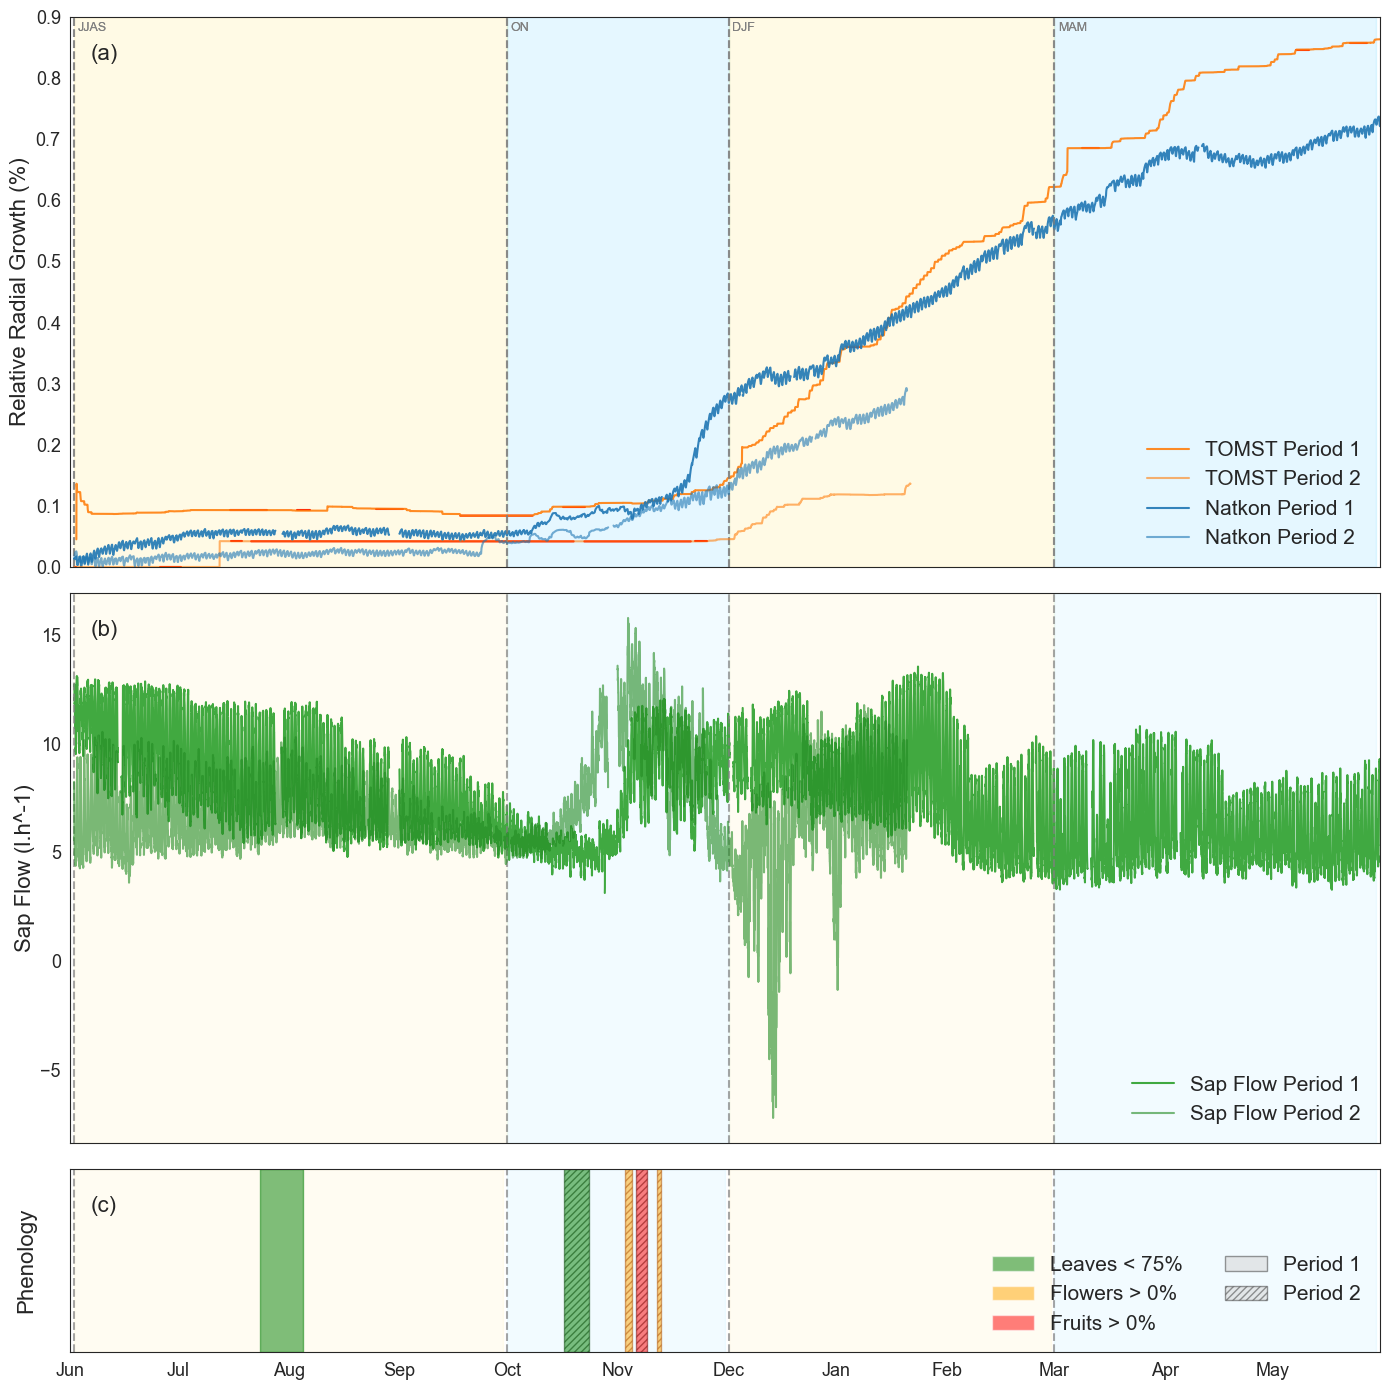

In [125]:

rcParams.update({
    'axes.titlesize': 18,    # a bit bigger
    'axes.labelsize': 16,    # slightly larger
    'xtick.labelsize': 13,   # easier to read
    'ytick.labelsize': 13,
    'legend.fontsize': 15
})

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 14), 
                                     sharex=True, 
                                     gridspec_kw={'height_ratios': [3, 3, 1]})

agg_to_plot = '20min'


if agg_to_plot == '20min':
    col_map = {s: 'smoothed_signal' for s in ['TOMST', 'Natkon', 'Sap Flow']}
elif agg_to_plot == 'roll10d':
    col_map = {s: 'smoothed_signal_roll10d' for s in ['TOMST', 'Natkon', 'Sap Flow']}
else:
    col_map = {s: f'smoothed_signal_mean_{agg_to_plot}' for s in ['TOMST', 'Natkon', 'Sap Flow']}

# Dendrometers
for sensor in ['TOMST', 'Natkon']:
    plotf.plot_sensor(df_all_norm, ax1, sensor, 
                      col_map[sensor] + '_pct_period',
                      'Relative Radial Growth (%)',
                      f'Normalized Stem Diameter [{agg_to_plot} aggregation]', 
                      sensor_colors, season_colors)

ax1.set_xlim(0, 365)
ax1.set_ylim(0, 0.9)

# Sap Flow
plotf.plot_sensor(df_all_norm, ax2, 'Sap Flow', col_map['Sap Flow'],
                  'Detrended Sap Flow (raw units)',
                  f'Sap Flow [{agg_to_plot} aggregation]', 
                  sensor_colors, season_colors, season_text=False)
ax2.set_ylabel('Sap Flow (l.h^-1)')
# ax2.set_xlabel('Day of Period (0–364)')
ax2.set_xlim(0, 365)

# Event timeline on the third subplot (existing ax3)
# plotf.plot_event_timeline(ax3, timeline_df)

x = df_phenocam_period['Day_of_Period']

# Masks
mask_leafs   = df_phenocam_period['%leafs']   < 75
mask_flowers = df_phenocam_period['%flowers'] > 0
mask_fruits  = df_phenocam_period['%fruits']  > 0

# Period masks
mask_p0 = df_phenocam_period['Period'] == 0
mask_p1 = df_phenocam_period['Period'] == 1

from matplotlib.patches import Patch

# --- Fill areas (no labels here)
ax3.fill_between(x, 0, 1, where=mask_leafs & mask_p0, color='green', alpha=0.5, transform=ax3.get_xaxis_transform())
ax3.fill_between(x, 0, 1, where=mask_leafs & mask_p1, color='green', alpha=0.5, hatch= '/////', edgecolor="#004200", transform=ax3.get_xaxis_transform())

ax3.fill_between(x, 0, 1, where=mask_flowers & mask_p0, color='orange', alpha=0.5, transform=ax3.get_xaxis_transform())
ax3.fill_between(x, 0, 1, where=mask_flowers & mask_p1, color='orange', alpha=0.5, hatch= '/////', edgecolor="#AD4E00", transform=ax3.get_xaxis_transform())

ax3.fill_between(x, 0, 1, where=mask_fruits & mask_p0, color='red', alpha=0.5, transform=ax3.get_xaxis_transform())
ax3.fill_between(x, 0, 1, where=mask_fruits & mask_p1, color='red', alpha=0.5, hatch= '/////', edgecolor="#740000", transform=ax3.get_xaxis_transform())

# --- Custom legend handles
phenology_handles = [
    Patch(facecolor='green', alpha = 0.5, label='Leaves < 75%'),
    Patch(facecolor='orange', alpha = 0.5, label='Flowers > 0%'),
    Patch(facecolor='red', alpha = 0.5, label='Fruits > 0%')
]

period_handles = [
    Patch(facecolor='lightgray', alpha=0.5, edgecolor = "#353535", label='Period 1'),
    Patch(facecolor='lightgray', alpha = 0.5, hatch='/////', edgecolor="#353535", label='Period 2')
]

# --- Combine and show legend
ax3.legend(handles=phenology_handles + period_handles, loc='lower right', ncol=2, frameon=False)
# Cosmetics
ax3.set_ylabel("Phenology", labelpad=25)
# remove y ticks
ax3.get_yaxis().set_ticks([])
ax3.set_xlim(0, 365)
# ax3.set_xlabel("Day of Period (0–364)")

# Month ticks for water year
month_starts = [ -1, 29, 60, 91, 121, 152, 183, 213, 244, 274, 305, 335 ]
month_labels = ['Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']
for i, ax in enumerate([ax1, ax2, ax3]): 
    ax.set_xticks(month_starts)
    if ax == ax3:
        ax.text(0.015, 0.85, f'({string.ascii_lowercase[i]})',
                        transform=ax.transAxes,
                        fontsize=16, va='top', ha='left')
    else:
        ax.text(0.015, 0.95, f'({string.ascii_lowercase[i]})',
                        transform=ax.transAxes,
                        fontsize=16, va='top', ha='left')


seasons = {'JJAS': {'start': 0, 'end': 120, 'type':'dry'},  # June–Sept
           'ON':   {'start': 121, 'end': 182, 'type':'wet'}, # Oct–Nov
           'DJF':  {'start': 183, 'end': 273, 'type':'dry'}, # Dec–Feb
           'MAM':  {'start': 274, 'end': 364, 'type':'wet'}  # Mar–May
           }

plotf.add_season_shading(seasons, season_colors, ax3, season_text = False)

ax3.set_xticklabels(month_labels)

# Adjust layout and show
plt.tight_layout()

plt.savefig('../outputs/figures/main_period_plot_phenology.png', dpi=600, bbox_inches='tight')
plt.show()

rcParams.update({
    'axes.titlesize': 18,    # a bit bigger
    'axes.labelsize': 14,    # slightly larger
    'xtick.labelsize': 12,   # easier to read
    'ytick.labelsize': 12,
    'legend.fontsize': 14
})


### PERIOD 1

In [126]:
start = 0
end = 237
period = 1

# df_phenocam_period[(df_phenocam_period['Period'] == period-1) & 
#                    (df_phenocam_period['Day_of_Period'] >= start) & 
#                    (df_phenocam_period['Day_of_Period'] <= end)]

# Get start date of this period
start_date_phen1 = df_phenocam_period.loc[
    (df_phenocam_period['Period'] == (period - 1)) & 
    (df_phenocam_period['Day_of_Period'] == start),
    'DateTime'
].iloc[0]
end_date_phen1 = df_phenocam_period.loc[
    (df_phenocam_period['Period'] == (period - 1)) & 
    (df_phenocam_period['Day_of_Period'] == end),
    'DateTime'
].iloc[0]

print(start_date_phen1)
print(end_date_phen1)

2023-06-08 10:00:00
2024-01-31 10:00:00


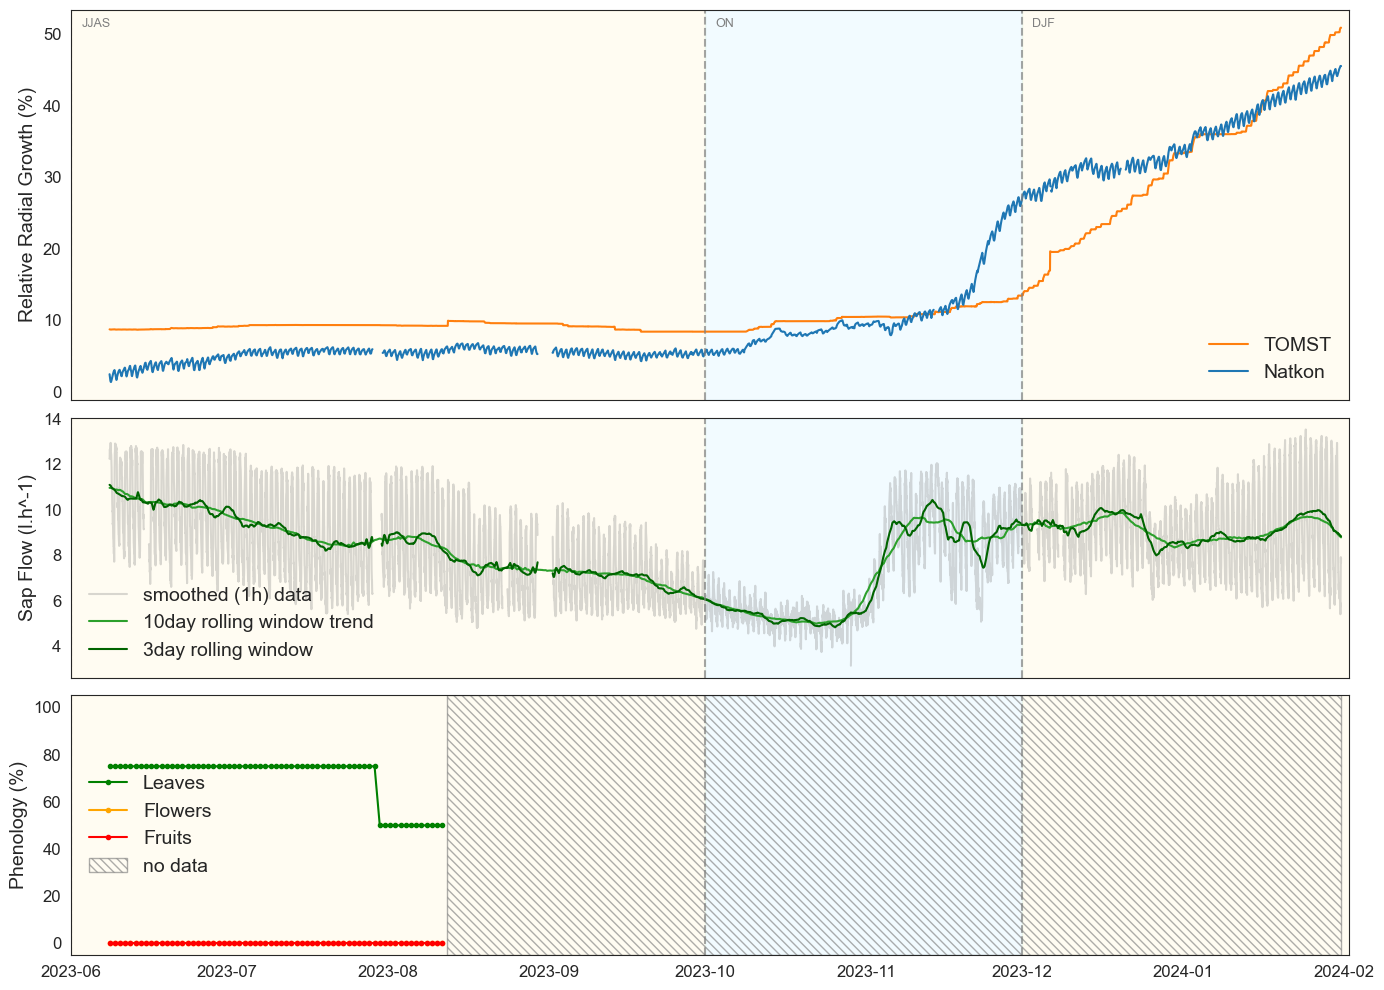

In [127]:
# --- Filter zoomed data ---
df_zoom1 = df_all_norm[(df_all_norm['DateTime'] >= start_date_phen1) & 
                      (df_all_norm['DateTime'] <= end_date_phen1)]

df_phen_zoom1 = df_phenocam_period[(df_phenocam_period['DateTime'] >= start_date_phen1) & 
                                  (df_phenocam_period['DateTime'] <= end_date_phen1)]

seasons_dates1 = {'JJAS': {'start': '2023-06-01 00:00:00', 'end': '2023-09-30 23:59:59', 'type':'dry'},  # June–Sept
           'ON':   {'start': '2023-10-01 00:00:00', 'end': '2023-11-30 23:59:59', 'type':'wet'}, # Oct–Nov
           'DJF':  {'start': '2023-12-01 00:00:00', 'end': '2024-02-28 23:59:59', 'type':'dry'}, # Dec–Feb
           'MAM':  {'start': '2024-03-01 00:00:00', 'end': '2024-05-31 23:59:59', 'type':'wet'}  # Mar–May
}

for s in seasons_dates1.values():
    s['start'] = pd.to_datetime(s['start'])
    s['end'] = pd.to_datetime(s['end'])


# --- Create subplots ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True, 
                                     gridspec_kw={'height_ratios': [3, 2, 2]})


# --- Top: dendrometer sensors ---
for sensor in ['TOMST', 'Natkon']:
    df_s = df_zoom1[df_zoom1['Sensor'] == sensor]
    ycol = 'smoothed_signal_pct_period'
    ax1.plot(df_s['DateTime'], df_s[ycol]*100, label=sensor, color = sensor_colors[sensor])

shared_xlim = ax1.get_xlim()

plotf.add_season_shading_dates(seasons_dates1, ax1, season_text = True, ypos = 0.98, xlim = shared_xlim)

ax1.set_ylabel('Relative Radial Growth (%)')
ax1.legend(loc = 'lower right', frameon = False)
# ax1.set_title(f'Period {period}: Zoomed Sensor and Phenology Data')

# --- Middle: Sap Flow ---
df_sap = df_zoom1[df_zoom1['Sensor'] == 'Sap Flow'].dropna(axis=1, how='all')

# ax2.plot(df_sap['DateTime'], df_sap['Detrended_flow'], color = 'red', alpha = 0.3, label='raw data')
ax2.plot(df_sap['DateTime'], df_sap['smoothed_signal'], color = 'gray', alpha = 0.3, label='smoothed (1h) data')
ax2.plot(df_sap['DateTime'], df_sap['smoothed_signal_roll10d'], color = sensor_colors['Sap Flow'], label='10day rolling window trend')
ax2.plot(df_sap["DateTime"], df_sap["short_trend"], color='darkgreen', label='3day rolling window')
plotf.add_season_shading_dates(seasons_dates1, ax2, season_text = False, xlim = shared_xlim)

ax2.set_ylabel('Sap Flow (l.h^-1)')
ax2.legend(loc = 'lower left', frameon = False)

# --- Bottom: Phenology ---
ax3.plot(df_phen_zoom1['DateTime'], df_phen_zoom1['%leafs'], color='green', label='Leaves', marker = 'o', markersize = 3)
ax3.plot(df_phen_zoom1['DateTime'], df_phen_zoom1['%flowers'], color='orange', label='Flowers',  marker = 'o', markersize = 3)
ax3.plot(df_phen_zoom1['DateTime'], df_phen_zoom1['%fruits'], color='red', label='Fruits',  marker = 'o', markersize = 3)
plotf.add_season_shading_dates(seasons_dates1, ax3, season_text = False, xlim = shared_xlim)

# Plot NaNs as grey markers
na_mask = df_phen_zoom1['%leafs'].isna()
missing_dates = df_phen_zoom1['DateTime'][na_mask].dropna().sort_values()

if not missing_dates.empty:
    gaps = np.split(missing_dates.to_numpy(), np.where(np.diff(missing_dates.to_numpy()) != np.timedelta64(1, 'D'))[0]+1)
    for i, gap in enumerate(gaps):
        ax3.axvspan(
            gap[0], gap[-1],
            facecolor="none",
            hatch='\\\\\\\\',
            edgecolor='#777777',
            alpha=0.6,
            label='no data' if i == 0 else None
        )

ax3.set_ylabel('Phenology (%)')
ax3.set_ylim(-5,105)
# ax3.set_xlabel('DateTime')
ax3.legend(loc = 'center left', frameon = False)

ax3.set_xlim(pd.Timestamp('2023-06-01'), pd.Timestamp('2024-02-02'))
plt.tight_layout()

plt.savefig("../outputs/figures/period1_phenology_events.png", dpi = 600, bbox_inches='tight')
plt.show()

### PERIOD 2

In [128]:
start = 0
end = 237
period = 2

# df_phenocam_period[(df_phenocam_period['Period'] == period-1) & 
#                    (df_phenocam_period['Day_of_Period'] >= start) & 
#                    (df_phenocam_period['Day_of_Period'] <= end)]

# Get start date of this period
start_date_phen = df_phenocam_period.loc[
    (df_phenocam_period['Period'] == (period - 1)) & 
    (df_phenocam_period['Day_of_Period'] == start),
    'DateTime'
].iloc[0]
end_date_phen = df_phenocam_period.loc[
    (df_phenocam_period['Period'] == (period - 1)) & 
    (df_phenocam_period['Day_of_Period'] == end),
    'DateTime'
].iloc[0]

print(start_date_phen)
print(end_date_phen)


2024-06-07 10:00:00
2025-01-30 10:00:00


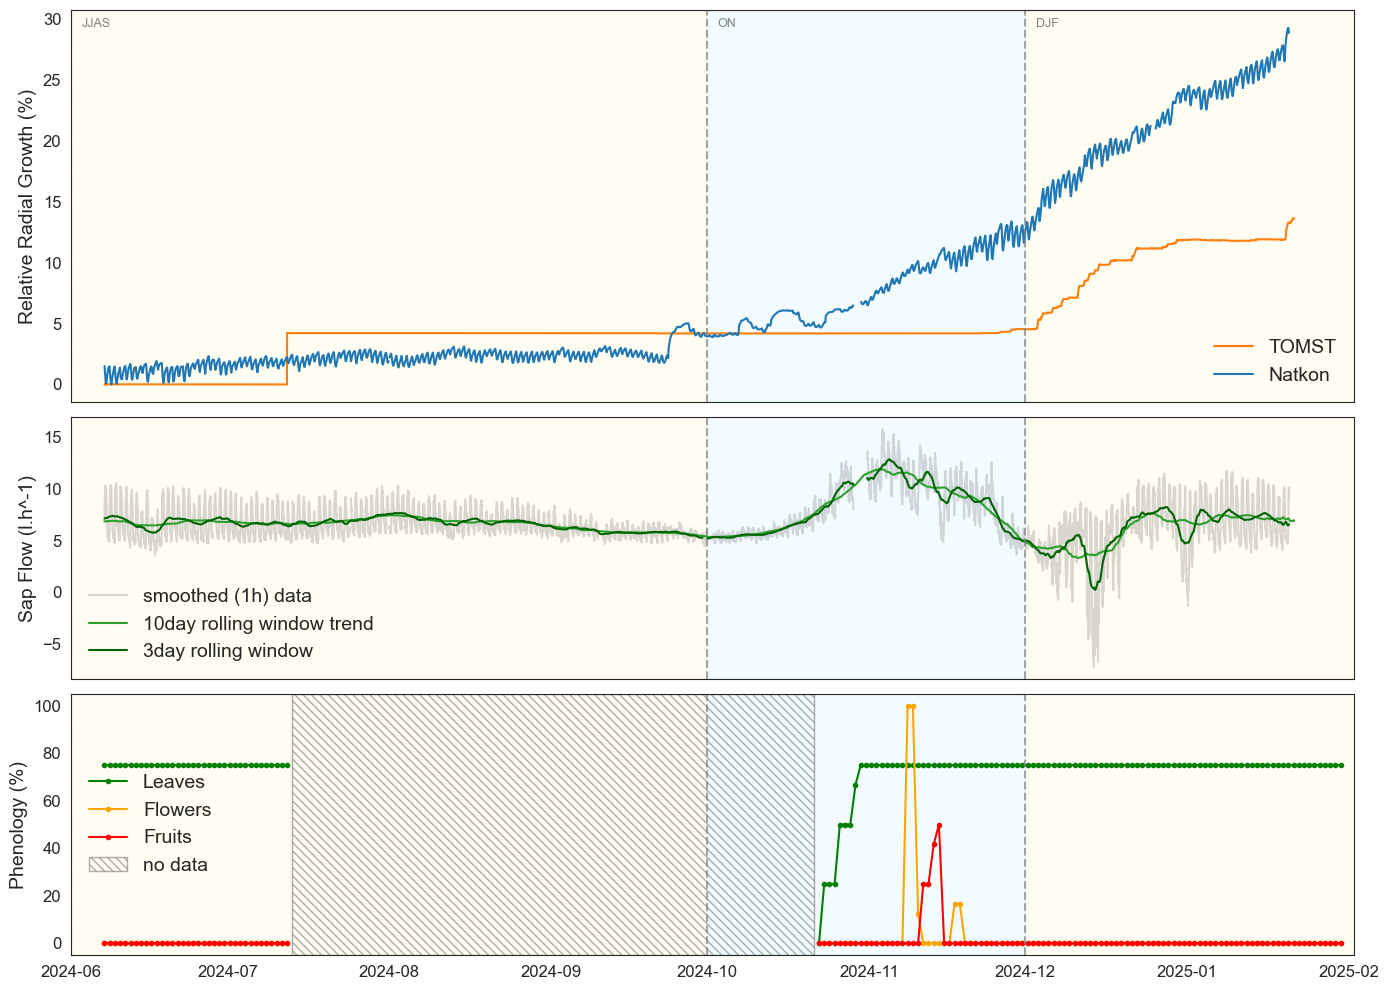

In [129]:
# --- Filter zoomed data ---
df_zoom2 = df_all_norm[(df_all_norm['DateTime'] >= start_date_phen) & 
                      (df_all_norm['DateTime'] <= end_date_phen)]

df_phen_zoom2 = df_phenocam_period[(df_phenocam_period['DateTime'] >= start_date_phen) & 
                                  (df_phenocam_period['DateTime'] <= end_date_phen)]

seasons_dates = {'JJAS': {'start': '2024-06-01 00:00:00', 'end': '2024-09-30 23:59:59', 'type':'dry'},  # June–Sept
           'ON':   {'start': '2024-10-01 00:00:00', 'end': '2024-11-30 23:59:59', 'type':'wet'}, # Oct–Nov
           'DJF':  {'start': '2024-12-01 00:00:00', 'end': '2025-02-28 23:59:59', 'type':'dry'}, # Dec–Feb
           'MAM':  {'start': '2025-03-01 00:00:00', 'end': '2025-05-31 23:59:59', 'type':'wet'}  # Mar–May
}

for s in seasons_dates.values():
    s['start'] = pd.to_datetime(s['start'])
    s['end'] = pd.to_datetime(s['end'])

sns.set_style("white")   # or "ticks", but pick one

# --- Create subplots ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True, 
                                     gridspec_kw={'height_ratios': [3, 2, 2]})


# --- Top: dendrometer sensors ---
for sensor in ['TOMST', 'Natkon']:
    df_s = df_zoom2[df_zoom2['Sensor'] == sensor]
    ycol = 'smoothed_signal_pct_period'
    ax1.plot(df_s['DateTime'], df_s[ycol]*100, label=sensor, color = sensor_colors[sensor])

shared_xlim = ax1.get_xlim()

plotf.add_season_shading_dates(seasons_dates, ax1, season_text = True, ypos = 0.98, xlim = shared_xlim)

ax1.set_ylabel('Relative Radial Growth (%)')
ax1.legend(loc = 'lower right', frameon = False)
# ax1.set_title(f'Period {period}: Zoomed Sensor and Phenology Data')

# --- Middle: Sap Flow ---
df_sap = df_zoom2[df_zoom2['Sensor'] == 'Sap Flow'].dropna(axis=1, how='all')

# ax2.plot(df_sap['DateTime'], df_sap['Detrended_flow'], color = 'red', alpha = 0.3, label='raw data')
ax2.plot(df_sap['DateTime'], df_sap['smoothed_signal'], color = 'gray', alpha = 0.3, label='smoothed (1h) data')
ax2.plot(df_sap['DateTime'], df_sap['smoothed_signal_roll10d'], color = sensor_colors['Sap Flow'], label='10day rolling window trend')
ax2.plot(df_sap["DateTime"], df_sap["short_trend"], color='darkgreen', label='3day rolling window')
plotf.add_season_shading_dates(seasons_dates, ax2, season_text = False, xlim = shared_xlim)

ax2.set_ylabel('Sap Flow (l.h^-1)')
ax2.legend(loc = 'lower left', frameon = False)

# --- Bottom: Phenology ---
ax3.plot(df_phen_zoom2['DateTime'], df_phen_zoom2['%leafs'], color='green', label='Leaves', marker = 'o', markersize = 3)
ax3.plot(df_phen_zoom2['DateTime'], df_phen_zoom2['%flowers'], color='orange', label='Flowers',  marker = 'o', markersize = 3)
ax3.plot(df_phen_zoom2['DateTime'], df_phen_zoom2['%fruits'], color='red', label='Fruits',  marker = 'o', markersize = 3)
plotf.add_season_shading_dates(seasons_dates, ax3, season_text = False, xlim = shared_xlim)

# Plot NaNs as grey markers
na_mask = df_phen_zoom2['%leafs'].isna()
missing_dates = df_phen_zoom2['DateTime'][na_mask].dropna().sort_values()

if not missing_dates.empty:
    gaps = np.split(missing_dates.to_numpy(), np.where(np.diff(missing_dates.to_numpy()) != np.timedelta64(1, 'D'))[0]+1)
    for i, gap in enumerate(gaps):
        ax3.axvspan(
            gap[0], gap[-1],
            facecolor="none",
            hatch='\\\\\\\\',
            edgecolor="#777777",
            alpha=0.6,
            label='no data' if i == 0 else None
        )

ax3.set_ylabel('Phenology (%)')
ax3.set_ylim(-5,105)
# ax3.set_xlabel('DateTime')
ax3.legend(loc = 'center left', frameon = False)

ax3.set_xlim(pd.Timestamp('2024-06-01'), pd.Timestamp('2025-02-02'))
plt.tight_layout()

plt.savefig("../outputs/figures/period2_phenology_events.png", dpi = 600, bbox_inches='tight')
plt.show()


# EXPORT

In [130]:
df_tomst_20.to_csv('../outputs/df_tomst_20.csv', index=False)
df_sap_flow_20.to_csv('../outputs/df_sap_flow_20.csv', index=False)
df_natkon_20.to_csv('../outputs/df_natkon_20.csv', index=False)

# save df_all to csv
df_all_norm.to_csv('../outputs/df_all.csv', index=False)

df_phenocam_period.to_csv('../outputs/df_phenocam_period.csv', index=False)

df_zoom1.to_csv("../outputs/df_zoom1.csv", index=False)
df_zoom2.to_csv("../outputs/df_zoom2.csv", index=False)